Jake Derby
DSC630-T302
07/13/25
Full Code File

In [1]:
# Let's start with loading in all of the libraries I will likely need for this milestone

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report

import xgboost as xgb
import shap
import lime.lime_tabular
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Loading the CSV file to a pandas df

import random

csv_path    = 'lending_club_data.csv'
sample_size = 200_000
reservoir   = []
n           = 0

for chunk in pd.read_csv(csv_path, chunksize=50_000, encoding='utf-8', encoding_errors='replace'):
    for _, row in chunk.iterrows():
        n += 1
        if len(reservoir) < sample_size:
            reservoir.append(row)
        else:
            # replace with decreasing probability
            s = random.randint(0, n-1)
            if s < sample_size:
                reservoir[s] = row

# build DataFrame from reservoir
raw_df = pd.DataFrame(reservoir)
print(f"Loaded a random sample of {len(raw_df)} rows")

FileNotFoundError: [Errno 2] No such file or directory: 'lending_club_data.csv'

In [4]:
# Checking dtypes
print(raw_df.dtypes)

id                       float64
member_id                float64
loan_amnt                  int64
funded_amnt                int64
funded_amnt_inv          float64
                          ...   
settlement_status         object
settlement_date           object
settlement_amount        float64
settlement_percentage    float64
settlement_term          float64
Length: 145, dtype: object


In [5]:
mixed_cols = raw_df.select_dtypes(include=['object']).columns.tolist()
print("Columns needing inspection:", mixed_cols)

Columns needing inspection: ['term', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d', 'application_type', 'verification_status_joint', 'sec_app_earliest_cr_line', 'hardship_flag', 'hardship_type', 'hardship_reason', 'hardship_status', 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', 'hardship_loan_status', 'disbursement_method', 'debt_settlement_flag', 'debt_settlement_flag_date', 'settlement_status', 'settlement_date']


In [6]:
# Let's inspect a few items from each mixed column to see what we are dealing with since not all of the column names are self-explanatory

for c in mixed_cols:
    print(c, "sample:", raw_df[c].dropna().unique()[:5])

term sample: [' 60 months' ' 36 months']
grade sample: ['D' 'E' 'A' 'C' 'F']
sub_grade sample: ['D4' 'E4' 'E5' 'A2' 'C1']
emp_title sample: ['Demand Planner' 'press operator' 'Principal Network Engineer' 'APM'
 'Sales Rep']
emp_length sample: ['10+ years' '2 years' '7 years' '5 years' '3 years']
home_ownership sample: ['RENT' 'MORTGAGE' 'OWN' 'ANY' 'OTHER']
verification_status sample: ['Verified' 'Source Verified' 'Not Verified']
issue_d sample: ['Dec-2017' 'Oct-2015' 'Mar-2014' 'Nov-2014' 'Feb-2018']
loan_status sample: ['Current' 'Fully Paid' 'Charged Off'
 'Does not meet the credit policy. Status:Charged Off'
 'Late (31-120 days)']
pymnt_plan sample: ['n' 'y']
desc sample: ["  Borrower added on 03/13/14 > I made a New Year Resolution to simplify my life and irradicate my personal debt. The purpose of the loan is to eliminate high interest credit card debt. I know it's going to take a several years to get rid of my debt, but I realize I need to begin somewhere.<br>"
 '  Borrower adde

In [7]:
# Looking at this closely, I feel confident in assigning the columns to their respective dtypes:

numeric_cols = [
    'funded_amnt_inv', 'delinq_2yrs', 'inq_last_6mths', 'open_acc',
    'pub_rec', 'total_acc', 'collections_12_mths_ex_med', 'acc_now_delinq',
    'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il',
    'open_il_12m', 'open_il_24m', 'total_bal_il', 'open_rv_12m',
    'open_rv_24m', 'max_bal_bc', 'total_rev_hi_lim', 'inq_fi',
    'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths',
    'avg_cur_bal', 'chargeoff_within_12_mths', 'delinq_amnt',
    'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
    'mort_acc', 'num_accts_ever_120_pd', 'num_actv_bc_tl',
    'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl',
    'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0',
    'num_sats', 'num_tl_30dpd', 'num_tl_90g_dpd_24m',
    'num_tl_op_past_12m', 'pub_rec_bankruptcies', 'tax_liens',
    'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
    'total_il_high_credit_limit'
]

category_cols = ['verification_status_joint']

text_cols = ['desc']

date_cols = ['sec_app_earliest_cr_line']

In [8]:
# Numeric to floats. Bad parsing will result in NaNs
for c in numeric_cols:
    raw_df[c] = pd.to_numeric(raw_df[c], errors='coerce')

# Categorical to pandas category
for c in category_cols:
    raw_df[c] = raw_df[c].astype('category')

# Text to pandas string, I don't want to leave as object
for c in text_cols:
    raw_df[c] = raw_df[c].astype('string')

# Dates to datetime; format '%b-%Y' handles 'May-2002'
for c in date_cols:
    raw_df[c] = pd.to_datetime(raw_df[c], format='%b-%Y', errors='coerce')

# Quick check
print(raw_df[numeric_cols].dtypes)
print(raw_df[category_cols].dtypes)
print(raw_df[text_cols].dtypes)
print(raw_df[date_cols].dtypes)

funded_amnt_inv               float64
delinq_2yrs                   float64
inq_last_6mths                float64
open_acc                      float64
pub_rec                       float64
total_acc                     float64
collections_12_mths_ex_med    float64
acc_now_delinq                float64
tot_coll_amt                  float64
tot_cur_bal                   float64
open_acc_6m                   float64
open_act_il                   float64
open_il_12m                   float64
open_il_24m                   float64
total_bal_il                  float64
open_rv_12m                   float64
open_rv_24m                   float64
max_bal_bc                    float64
total_rev_hi_lim              float64
inq_fi                        float64
total_cu_tl                   float64
inq_last_12m                  float64
acc_open_past_24mths          float64
avg_cur_bal                   float64
chargeoff_within_12_mths      float64
delinq_amnt                   float64
mo_sin_old_r

In [9]:
# Sweet, let's check now to see how many NaNs we introduced to the dataset now

print(raw_df[mixed_cols].isna().sum())

term                              0
grade                             0
sub_grade                         0
emp_title                     14793
emp_length                    13002
home_ownership                    0
verification_status               0
issue_d                           0
loan_status                       0
pymnt_plan                        0
desc                         188746
purpose                           0
title                          2128
zip_code                          1
addr_state                        0
earliest_cr_line                  3
initial_list_status               0
last_pymnt_d                    238
next_pymnt_d                 115285
last_credit_pull_d                6
application_type                  0
verification_status_joint    189867
sec_app_earliest_cr_line     190492
hardship_flag                     0
hardship_type                199085
hardship_reason              199085
hardship_status              199085
hardship_start_date         

In [10]:
# Let's deal with the NaNs now. Let's first get a quick fraction of missing values for each column and go from there.

n = len(raw_df)
missing_frac = raw_df[mixed_cols].isna().sum() / n
print(missing_frac.sort_values(ascending=False))

payment_plan_start_date      0.995425
hardship_loan_status         0.995425
hardship_end_date            0.995425
hardship_type                0.995425
hardship_status              0.995425
hardship_reason              0.995425
hardship_start_date          0.995425
debt_settlement_flag_date    0.985895
settlement_status            0.985895
settlement_date              0.985895
sec_app_earliest_cr_line     0.952460
verification_status_joint    0.949335
desc                         0.943730
next_pymnt_d                 0.576425
emp_title                    0.073965
emp_length                   0.065010
title                        0.010640
last_pymnt_d                 0.001190
last_credit_pull_d           0.000030
earliest_cr_line             0.000015
zip_code                     0.000005
sub_grade                    0.000000
term                         0.000000
grade                        0.000000
issue_d                      0.000000
loan_status                  0.000000
pymnt_plan  

In [11]:
# Let's drop high NaN columns (greater than 30% missing, except for a couple variables I think might be worth keeping)

from sklearn.impute import SimpleImputer

# Defining those columns I want to keep
keep_cols = ['inq_fi', 'inq_last_12m']

# Dropping columns with >30% missing, excluding keep_cols
to_drop = missing_frac[missing_frac > 0.3].index.difference(keep_cols)
to_drop = [c for c in to_drop if c in raw_df.columns]
raw_df.drop(columns=to_drop, inplace=True)

# Redefining the column groups
numeric_cols = [
    'funded_amnt_inv', 'delinq_2yrs', 'inq_last_6mths', 'open_acc',
    'pub_rec', 'total_acc', 'collections_12_mths_ex_med',
    'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m',
    'open_act_il', 'open_il_12m', 'open_il_24m', 'total_bal_il',
    'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'total_rev_hi_lim',
    'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths',
    'avg_cur_bal', 'chargeoff_within_12_mths', 'delinq_amnt',
    'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
    'mort_acc', 'num_accts_ever_120_pd', 'num_actv_bc_tl',
    'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl',
    'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0',
    'num_sats', 'num_tl_30dpd', 'num_tl_90g_dpd_24m',
    'num_tl_op_past_12m', 'pub_rec_bankruptcies', 'tax_liens',
    'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
    'total_il_high_credit_limit'
]
category_cols = ['verification_status_joint']
text_cols = ['desc']
date_cols = ['sec_app_earliest_cr_line']

# Now keeping only those that survived the drop
numeric_cols   = [c for c in numeric_cols if c in raw_df.columns]
category_cols  = [c for c in category_cols if c in raw_df.columns]
text_cols      = [c for c in text_cols if c in raw_df.columns]
date_cols      = [c for c in date_cols if c in raw_df.columns]

# Let's do a median-impute for the numerics
num_imputer = SimpleImputer(strategy='median')
raw_df[numeric_cols] = num_imputer.fit_transform(raw_df[numeric_cols])

# Filling categorical col with 'Unknown', if it survived
for c in category_cols:
    raw_df[c] = raw_df[c].cat.add_categories('Unknown').fillna('Unknown')

# Filling text with empty string
for c in text_cols:
    raw_df[c] = raw_df[c].fillna('')

# Imputing dates with the column-minimum
for c in date_cols:
    raw_df[c] = raw_df[c].fillna(raw_df[c].min())

# Verifying that there are no more missing values
print(raw_df.isna().sum().sort_values(ascending=False).head())

id                                            200000
member_id                                     200000
url                                           200000
orig_projected_additional_accrued_interest    199269
hardship_payoff_balance_amount                199085
dtype: int64


In [12]:
# The remaining high NaN columns are not useful or likely to be predictive so I will drop them now

cols_to_drop = [
    'id',
    'url',
    'member_id',
    'orig_projected_additional_accrued_interest',
    'hardship_length'
]

# Only drop those that actually exist in df (to avoid KeyErrors)
cols_to_drop = [c for c in cols_to_drop if c in raw_df.columns]

# Drop them in place
raw_df.drop(columns=cols_to_drop, inplace=True)

In [13]:
df = raw_df.copy()

In [14]:
# Now that the df is cleaned up, let's define and inspect the target (defualt)

# Inspecting the raw loan_status distribution
print(df['loan_status'].value_counts())

# Creating a 0/1 flag since this is what we want to predict: 1 = Default (or Charged Off), 0 = Fully Paid (or current)
df['is_default'] = df['loan_status'].isin(['Default','Charged Off']).astype(int)

# Checking the balance of our target
print(df['is_default'].value_counts(normalize=True))

loan_status
Fully Paid                                             92307
Current                                                81469
Charged Off                                            22978
Late (31-120 days)                                      1879
In Grace Period                                          761
Late (16-30 days)                                        343
Does not meet the credit policy. Status:Fully Paid       184
Does not meet the credit policy. Status:Charged Off       77
Default                                                    2
Name: count, dtype: int64
is_default
0    0.8851
1    0.1149
Name: proportion, dtype: float64


In [15]:
# Okay so I might have jumped the gun a little with defining the target. Let's get rid of rows that represent loans that have not yet closed.

finished_statuses = [
    'Fully Paid',
    'Does not meet the credit policy. Status:Fully Paid',
    'Charged Off',
    'Does not meet the credit policy. Status:Charged Off',
    'Default'
]

# Filtering to only those loans
df_final = df[df['loan_status'].isin(finished_statuses)].copy()

# Mapping each to 0 (non-default) or 1 (default)
status_map = {
    'Fully Paid': 0,
    'Does not meet the credit policy. Status:Fully Paid': 0,
    'Charged Off': 1,
    'Does not meet the credit policy. Status:Charged Off': 1,
    'Default': 1
}
df_final['is_default'] = df_final['loan_status'].map(status_map)

# Checking the new balance of our target with finished loans only
print(df_final['loan_status'].value_counts())
print(df_final['is_default'].value_counts(normalize=True))

loan_status
Fully Paid                                             92307
Charged Off                                            22978
Does not meet the credit policy. Status:Fully Paid       184
Does not meet the credit policy. Status:Charged Off       77
Default                                                    2
Name: count, dtype: int64
is_default
0    0.800455
1    0.199545
Name: proportion, dtype: float64


In [16]:
# Defining the numeric and categorical lists on our final df
numeric_cols_final = [c for c in numeric_cols if c in df_final.columns]
cat_cols_final     = df_final.select_dtypes(['category','object']).columns.tolist()

In [17]:
# Let's get some numeric summary statistics
num_summary = df_final[numeric_cols_final].describe().T
print(num_summary[['count','mean','std','min','25%','50%','75%','max']])

                               count           mean            std  min  \
funded_amnt_inv             115548.0   14330.090254    8685.209093  0.0   
delinq_2yrs                 115548.0       0.318188       0.873514  0.0   
inq_last_6mths              115548.0       0.665092       0.967103  0.0   
open_acc                    115548.0      11.579482       5.455340  0.0   
pub_rec                     115548.0       0.216153       0.659614  0.0   
total_acc                   115548.0      24.992514      11.973813  1.0   
collections_12_mths_ex_med  115548.0       0.017101       0.147627  0.0   
acc_now_delinq              115548.0       0.005037       0.076662  0.0   
tot_coll_amt                115548.0     218.710025    1842.785903  0.0   
tot_cur_bal                 115548.0  138415.716291  155496.127656  0.0   
open_acc_6m                 115548.0       1.022856       0.752543  0.0   
open_act_il                 115548.0       2.308409       1.897937  0.0   
open_il_12m              

In [18]:
# Getting categorical counts (showing top 10 for each)
for c in cat_cols_final:
    print(f"\n=== {c} ===")
    print(df_final[c].value_counts(dropna=False).head(10))


=== term ===
term
36 months    87820
60 months    27728
Name: count, dtype: int64

=== grade ===
grade
B    33679
C    33020
A    19992
D    17238
E     8005
F     2790
G      824
Name: count, dtype: int64

=== sub_grade ===
sub_grade
C1    7399
B3    7127
B4    7111
B5    7010
C2    6832
C3    6490
C4    6388
B2    6325
B1    6106
C5    5911
Name: count, dtype: int64

=== emp_title ===
emp_title
NaN                 7377
Teacher             1851
Manager             1603
Owner                883
Registered Nurse     749
Supervisor           727
RN                   705
Sales                624
Driver               617
Project Manager      575
Name: count, dtype: int64

=== emp_length ===
emp_length
10+ years    37799
2 years      10453
3 years       9313
< 1 year      9292
1 year        7464
5 years       7145
4 years       7018
NaN           6726
6 years       5483
8 years       5311
Name: count, dtype: int64

=== home_ownership ===
home_ownership
MORTGAGE    57152
RENT        45997
O

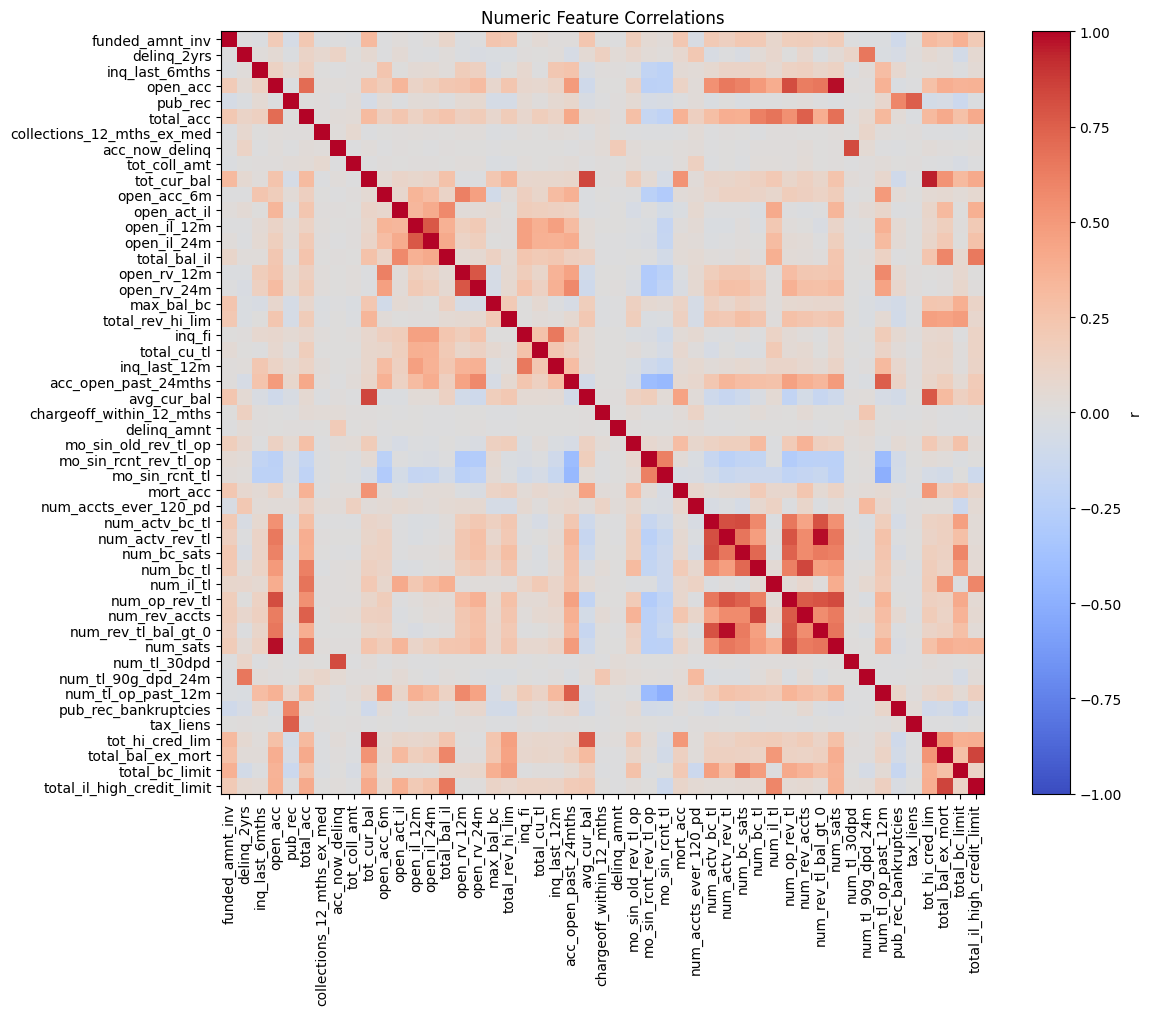

In [19]:
# Correlation matrix for all numerics
corr = df_final[numeric_cols_final].corr()
plt.figure(figsize=(12,10))
plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='r')
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.index)
plt.title("Numeric Feature Correlations")
plt.tight_layout()
plt.show()

In [20]:
# Correlation of each numeric feature with our target
corr_with_target = df_final[numeric_cols_final + ['is_default']].corr()['is_default'].drop('is_default')
print("\nTop positive correlations with default:")
print(corr_with_target.sort_values(ascending=False).head(10))
print("\nTop negative correlations with default:")
print(corr_with_target.sort_values().head(10))


Top positive correlations with default:
acc_open_past_24mths    0.093796
num_tl_op_past_12m      0.083878
num_actv_rev_tl         0.070258
num_rev_tl_bal_gt_0     0.069371
funded_amnt_inv         0.065450
open_rv_24m             0.062466
inq_last_6mths          0.062046
inq_last_12m            0.055820
open_il_12m             0.052010
open_rv_12m             0.050722
Name: is_default, dtype: float64

Top negative correlations with default:
avg_cur_bal             -0.072580
mort_acc                -0.072193
total_bc_limit          -0.071765
tot_hi_cred_lim         -0.070747
tot_cur_bal             -0.066398
mo_sin_rcnt_tl          -0.054052
mo_sin_rcnt_rev_tl_op   -0.050783
mo_sin_old_rev_tl_op    -0.043127
total_rev_hi_lim        -0.036878
max_bal_bc              -0.016701
Name: is_default, dtype: float64


In [21]:
# Let's just run a simple logistic regression with all of the features in the df currently, minus the categorical ones (we'll have
# to process those shortly). I'm curious what we are looking at without any feature selection or engineering

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# Preparing our feature matrix and target (the predictive features will need to be adjusted obviously, but let's just get a baseline, for-fun model)
# 80% train would be about 92k samples
df_samp, _ = train_test_split(
    df_final,
    train_size=92_000,
    stratify=df_final['is_default'],
    random_state=42
)

# Using only numeric features
X = df_samp[numeric_cols_final]
y = df_samp['is_default']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Fitting a simple logistic (liblinear is fine on ~dozens of cols)
lr = LogisticRegression(
    solver='liblinear',
    class_weight='balanced',  # optional: helps with imbalance
    max_iter=1000
)
lr.fit(X_train, y_train)

# Evaluating on the hold-out
y_proba = lr.predict_proba(X_test)[:,1]
y_pred  = lr.predict(X_test)

print(f"Hold-out ROC AUC: {roc_auc_score(y_test, y_proba):.3f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Hold-out ROC AUC: 0.645

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.55      0.67     14728
           1       0.27      0.66      0.38      3672

    accuracy                           0.57     18400
   macro avg       0.57      0.60      0.52     18400
weighted avg       0.75      0.57      0.61     18400



<Figure size 640x480 with 0 Axes>

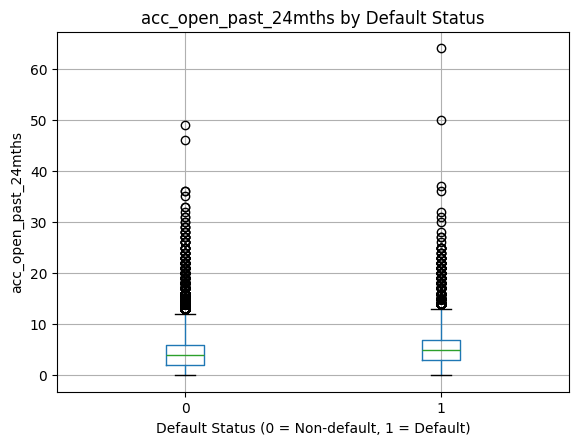

<Figure size 640x480 with 0 Axes>

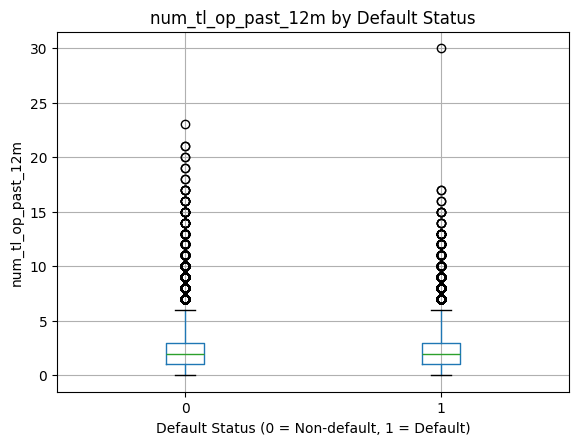

<Figure size 640x480 with 0 Axes>

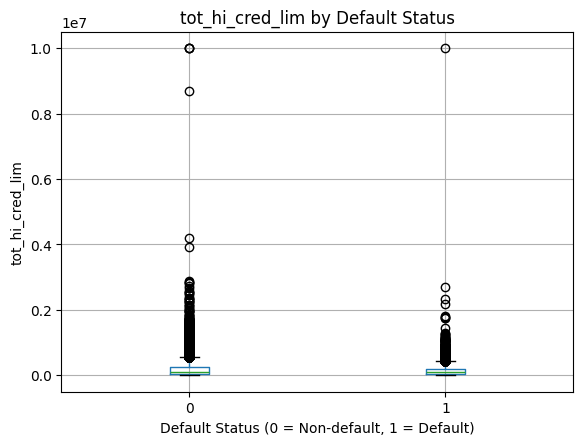

<Figure size 640x480 with 0 Axes>

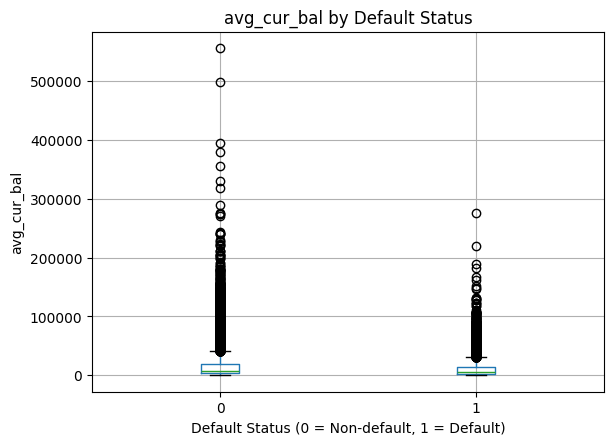

In [22]:
# That was fun, but let's get a better idea of the distribution of some of our features that are most correlated with the target variable

features = [
    'acc_open_past_24mths',
    'num_tl_op_past_12m',
    'tot_hi_cred_lim',
    'avg_cur_bal'
]

for feat in features:
    plt.figure()
    df_final.boxplot(column=feat, by='is_default')
    plt.title(f'{feat} by Default Status')
    plt.suptitle('')            # remove automatic “Boxplot grouped by…” subtitle
    plt.xlabel('Default Status (0 = Non-default, 1 = Default)')
    plt.ylabel(feat)
    plt.show()

In [23]:
# So it appears we have some seriously right-skewed distributions for some of these most important features. That is not surprising and we will
# need to handle that in the future. Once I get to my feature selection stage, I will likely bin a lot of these skewed features to use in the models.

print(df_final[features].skew())

acc_open_past_24mths    1.483429
num_tl_op_past_12m      1.531455
tot_hi_cred_lim         8.551173
avg_cur_bal             4.213033
dtype: float64


------------- POST MILESTONE 3 ------------

In [24]:
from sklearn.feature_selection import VarianceThreshold

numeric_feats = df_final.select_dtypes(include='number').columns.drop('is_default')
sel = VarianceThreshold(threshold=0.01)
sel.fit(df_final[numeric_feats])
low_var_feats = [f for f, keep in zip(numeric_feats, sel.get_support()) if not keep]

print("Low-variance candidates:", low_var_feats)

# For each, compare group default rates
global_rate = df_final['is_default'].mean()

for feat in low_var_feats:
    rates = (
        df_final
        .groupby(feat)['is_default']
        .agg(['count','mean'])
        .sort_index()
    )
    rates['diff'] = (rates['mean'] - global_rate).abs()
    print(f"\nFeature: {feat}")
    print(rates)

Low-variance candidates: ['policy_code', 'acc_now_delinq', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'deferral_term']

Feature: policy_code
              count      mean  diff
policy_code                        
1            115548  0.199545   0.0

Feature: acc_now_delinq
                 count      mean      diff
acc_now_delinq                            
0.0             115006  0.199520  0.000025
1.0                510  0.201961  0.002416
2.0                 26  0.269231  0.069686
3.0                  4  0.250000  0.050455
4.0                  2  0.000000  0.199545

Feature: num_tl_120dpd_2m
                   count      mean      diff
num_tl_120dpd_2m                            
0.0               105008  0.198871  0.000674
1.0                   82  0.170732  0.028813
2.0                    4  0.000000  0.199545

Feature: num_tl_30dpd
               count      mean      diff
num_tl_30dpd                            
0.0           115197  0.199554  0.000009
1.0              328  0.192073  0.

In [25]:
# So policy_code is a useless variable we didn't catch before. We will drop that one outright now. As for the other low-variance features,
# it looks like their non-modal instances might add some predictive "lift" to a model and might be worth keeping, but not in their raw count
# form. The simplest solution is to recode them into binary features indicating whether the is is 0 or not. 

# List all the low-variance columns we want to recode and drop
to_flag   = ['acc_now_delinq', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'deferral_term']
to_drop   = ['policy_code'] + to_flag

# Dropping any of those that aren’t in df_final anymore 
cols_to_drop = [c for c in to_drop if c in df_final.columns]
df_final.drop(columns=cols_to_drop, inplace=True)

# For each original column that still exists, create the binary flag
for c in to_flag:
    if c in df_final.columns:
        df_final[f'{c}_flag'] = (df_final[c] > 0).astype(int)

# Now dropping the original count columns (again, only if present)
orig_cols_present = [c for c in to_flag if c in df_final.columns]
df_final.drop(columns=orig_cols_present, inplace=True)

# Verify
print("Flags:", [col for col in df_final.columns if col.endswith('_flag')])
print("Dropped originals still present?", 
      any(c in df_final.columns for c in to_drop))

Flags: ['hardship_flag', 'debt_settlement_flag']
Dropped originals still present? False


In [26]:
# Identify all numeric columns again (including our new flags but excluding the target)
num_feats = df_final.select_dtypes(include=[np.number]).columns.drop('is_default')

# Computing the absolute correlation matrix again
corr_matrix = df_final[num_feats].corr().abs()

# Creating an upper-triangle mask so we don’t double-count pairs
upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

# Finding features to drop. Any with a correlation > corr_thr to a higher-priority feature
corr_thr = 0.90
to_drop = [col for col in upper.columns if any(upper[col] > corr_thr)]

print(f"Dropping {len(to_drop)} highly correlated features:", to_drop)

# Dropping them in place
df_final.drop(columns=to_drop, inplace=True)

# Checking how many remain
print("Features remaining:", len(df_final.columns) - 1)  # excluding the target

Dropping 11 highly correlated features: ['funded_amnt', 'funded_amnt_inv', 'installment', 'out_prncp_inv', 'total_pymnt_inv', 'total_rec_prncp', 'collection_recovery_fee', 'num_rev_tl_bal_gt_0', 'num_sats', 'tot_hi_cred_lim', 'settlement_amount']
Features remaining: 110


In [27]:
# Let's drop zip_code from the dataset as this could be used as a proxy for unfair discrimination

df_final.drop(columns=['zip_code'], inplace=True)

In [28]:
dtype_dict = df_final.dtypes.to_dict()
for col, dt in dtype_dict.items():
    print(f"{col}: {dt}")

loan_amnt: int64
term: object
int_rate: float64
grade: object
sub_grade: object
emp_title: object
emp_length: object
home_ownership: object
annual_inc: float64
verification_status: object
issue_d: object
loan_status: object
pymnt_plan: object
purpose: object
title: object
addr_state: object
dti: float64
delinq_2yrs: float64
earliest_cr_line: object
inq_last_6mths: float64
mths_since_last_delinq: float64
mths_since_last_record: float64
open_acc: float64
pub_rec: float64
revol_bal: int64
revol_util: float64
total_acc: float64
initial_list_status: object
out_prncp: float64
total_pymnt: float64
total_rec_int: float64
total_rec_late_fee: float64
recoveries: float64
last_pymnt_d: object
last_pymnt_amnt: float64
last_credit_pull_d: object
collections_12_mths_ex_med: float64
mths_since_last_major_derog: float64
application_type: object
annual_inc_joint: float64
dti_joint: float64
tot_coll_amt: float64
tot_cur_bal: float64
open_acc_6m: float64
open_act_il: float64
open_il_12m: float64
open_il_2

In [29]:
# selecting categorical columns (object or category) again
cat_cols = df_final.select_dtypes(include=['object', 'category']).columns

# how many categorical features
n_cat = len(cat_cols)
print(f"Number of categorical columns: {n_cat}")

# unique-value count per categorical column
unique_counts = df_final[cat_cols].nunique().sort_values(ascending=False)
print("\nUnique-value counts for each categorical column:")
print(unique_counts)

Number of categorical columns: 21

Unique-value counts for each categorical column:
emp_title               50558
title                    7847
earliest_cr_line          652
issue_d                   139
last_pymnt_d              134
last_credit_pull_d        121
addr_state                 50
sub_grade                  35
purpose                    14
emp_length                 11
grade                       7
home_ownership              6
loan_status                 5
verification_status         3
term                        2
application_type            2
initial_list_status         2
debt_settlement_flag        2
disbursement_method         2
pymnt_plan                  1
hardship_flag               1
dtype: int64


In [30]:
# I am dropping these categorical columns for the concern of data leakage into the model. Loan_status, for example, obviously doesn't
# belong in the predictors.

cols_to_drop = [
    'loan_status',
    'pymnt_plan',
    'hardship_flag',
    'last_pymnt_d',
    'last_credit_pull_d'
]

df_final.drop(columns=cols_to_drop, inplace=True)

In [31]:
# I want to get # days since the applicants earliest credit line. This variable would be much better suited as a numeric feature
# than the current date format

# Parsing the date‐string columns
df_final['earliest_cr_line'] = pd.to_datetime(
    df_final['earliest_cr_line'], infer_datetime_format=True
)
df_final['issue_d'] = pd.to_datetime(
    df_final['issue_d'], infer_datetime_format=True
)

# Making the numeric feature we want (days since first credit line)
df_final['earliest_cr_line_days'] = (
    df_final['issue_d'] - df_final['earliest_cr_line']
).dt.days

# Dropping the originals
df_final.drop(columns=['earliest_cr_line', 'issue_d'], inplace=True)

# sanity check
print(df_final[['earliest_cr_line_days']].head())

         earliest_cr_line_days
1023587                 4017.0
2059371                 7578.0
1878712                 6301.0
1148975                 4321.0
996159                 11353.0


C:\Users\jaked\AppData\Local\Temp\ipykernel_27124\1590402649.py:5: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_final['earliest_cr_line'] = pd.to_datetime(
C:\Users\jaked\AppData\Local\Temp\ipykernel_27124\1590402649.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_final['earliest_cr_line'] = pd.to_datetime(
C:\Users\jaked\AppData\Local\Temp\ipykernel_27124\1590402649.py:8: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this a

In [32]:
# Finding top 10 for each
top10_emp = df_final['emp_title'].value_counts().nlargest(10).index
top10_title = df_final['title'].value_counts().nlargest(10).index

# Collapsing to “Other” for everything else
df_final['emp_title_reduced'] = df_final['emp_title'].where(
    df_final['emp_title'].isin(top10_emp), other='Other'
)
df_final['title_reduced'] = df_final['title'].where(
    df_final['title'].isin(top10_title), other='Other'
)

# One-hot encode the reduced columns (this way we avoid exploding the dataset)
df_final = pd.get_dummies(
    df_final,
    columns=['emp_title_reduced', 'title_reduced'],
    prefix=['emp_title', 'title'],
    drop_first=False,
    sparse=True              # this makes the new columns sparse, avoiding memory issues I've been running into
)

# Dropping the originals
df_final.drop(columns=['emp_title', 'title'], inplace=True)

# sanity check
print("New emp_title dummies:", 
      [c for c in df_final.columns if c.startswith('emp_title_')])
print("New title dummies:", 
      [c for c in df_final.columns if c.startswith('title_')])

New emp_title dummies: ['emp_title_Driver', 'emp_title_Manager', 'emp_title_Office Manager', 'emp_title_Other', 'emp_title_Owner', 'emp_title_Project Manager', 'emp_title_RN', 'emp_title_Registered Nurse', 'emp_title_Sales', 'emp_title_Supervisor', 'emp_title_Teacher']
New title dummies: ['title_Business', 'title_Car financing', 'title_Credit card refinancing', 'title_Debt Consolidation', 'title_Debt consolidation', 'title_Home improvement', 'title_Major purchase', 'title_Medical expenses', 'title_Other', 'title_Vacation']


In [33]:
# Now for the final step regarding converting our categoricals. Let's drop the addr_state (for the same reason we dropped zip_code).
# We'll ordinal-encode the truly ordered features, sparsely one-hot encode the remaining low-cardinality features and get
# numeric binaries for the binary features. 

from sklearn.preprocessing import OrdinalEncoder

# Drop addr_state first
df_final.drop(columns=['addr_state'], inplace=True)

# Ordinal‑encoding grade, sub_grade, emp_length, term
ord_cols = ['grade', 'sub_grade', 'emp_length', 'term']
ord_enc = OrdinalEncoder()
df_final[ord_cols] = ord_enc.fit_transform(df_final[ord_cols])

# One‑hot encoding purpose, home_ownership, verification_status
onehot_cols = ['purpose', 'home_ownership', 'verification_status']
df_final = pd.get_dummies(
    df_final,
    columns=onehot_cols,
    drop_first=False,   # keep all levels or set True to drop one per group
    sparse=True         # makes the new dummy columns Sparse[int8]
)

# Converting the remaining binary flags to 0/1
binary_cols = [
    'initial_list_status',
    'application_type',
    'disbursement_method',
    'debt_settlement_flag'
]
# pandas will map categories to 0...n-1; with two levels that gives 0/1
df_final[binary_cols] = df_final[binary_cols].apply(
    lambda s: s.astype('category').cat.codes
)

# confirm
print("Remaining categorical‑turned‑numeric & sparse columns:")
print([c for c in df_final.columns 
       if c in ord_cols 
       or any(c.startswith(prefix + "_") for prefix in onehot_cols) 
       or c in binary_cols])

Remaining categorical‑turned‑numeric & sparse columns:
['term', 'grade', 'sub_grade', 'emp_length', 'initial_list_status', 'application_type', 'disbursement_method', 'debt_settlement_flag', 'purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation', 'purpose_educational', 'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase', 'purpose_medical', 'purpose_moving', 'purpose_other', 'purpose_renewable_energy', 'purpose_small_business', 'purpose_vacation', 'purpose_wedding', 'home_ownership_ANY', 'home_ownership_MORTGAGE', 'home_ownership_NONE', 'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT', 'verification_status_Not Verified', 'verification_status_Source Verified', 'verification_status_Verified']


In [34]:
# Looking at the full list of remaining variables, there are still a handful that are not appropriate to include in the list of 
# predictor variables. Many of them have to do with settlement terms and stuff like that, which obviously leak information about
# loan success after the fact which we are not interested in (only those things that are truly known at the time of the loan
# decision should be included). Let's take care of that now and then finally move on to building the random forest

# List of leaky columns
leak_cols = [
    'out_prncp',
    'total_pymnt',
    'total_rec_int',
    'total_rec_late_fee',
    'recoveries',
    'last_pymnt_amnt',
    'settlement_percentage',
    'settlement_term'
]

# Dropping them in‑place from df_final
df_final.drop(columns=leak_cols, inplace=True)

# Sanity check
print("Dropped leak columns:", leak_cols)
print("Remaining columns count:", len(df_final.columns))

Dropped leak columns: ['out_prncp', 'total_pymnt', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'last_pymnt_amnt', 'settlement_percentage', 'settlement_term']
Remaining columns count: 134


In [35]:
# NOTE: I am adding this cell before the random forest cell because the top feature was "debt_settlement_flag" which is obviously
# a leaky variable we missed. 

df_final.drop(columns=['debt_settlement_flag'], inplace=True)

In [36]:
# Let's do our random forest classifier now with the variables we have left. We'll get the feature importances and keep around the top 20 most
# important features to use as our core feature set for the rest of the models going forward. Random forest feature importances is a good method
# because it is non-parametric and does not assume linearity, so it can capture complex relationships in the data with ease

# Splitting out X (predictors) and y (target, is_default)
X = df_final.drop(columns=['is_default'])
y = df_final['is_default']

# Train/test split
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=18
)

# Instantiate the model
rf = RandomForestClassifier(
    n_estimators=100,  
    max_depth=None,     
    n_jobs=-1,          # this line tells the model to use all cores on the laptop
    random_state=18
)

# Fit the model
rf.fit(X_train, y_train)

# Grabbing feature importances from the model
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

# Displaying the top 20
print("Top 20 feature importances:")
print(importances.head(20))

c:\Users\jaked\dsc630\venv\Lib\site-packages\sklearn\utils\validation.py:919: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Top 20 feature importances:
int_rate                 0.035253
sub_grade                0.030626
dti                      0.029941
mo_sin_old_il_acct       0.024552
earliest_cr_line_days    0.024520
annual_inc               0.024287
bc_open_to_buy           0.024250
revol_util               0.024052
loan_amnt                0.023768
revol_bal                0.023271
avg_cur_bal              0.023069
bc_util                  0.022896
mo_sin_old_rev_tl_op     0.022615
tot_cur_bal              0.022213
total_bc_limit           0.021488
total_bal_ex_mort        0.021237
total_rev_hi_lim         0.021166
mths_since_recent_bc     0.019807
total_acc                0.019799
grade                    0.019155
dtype: float64


In [37]:
# So let's train and analyze a random forest model with our core set of features. I'm going to drop sub_grade and grade since they are
# practically the same signals as int_rate. I'll also drop revol_bal as that is likely very similar to revol_util. 

from sklearn.metrics import confusion_matrix, classification_report

# Defining the 17 core features we want to use going forward
core_feats = [
    'int_rate',
    'dti',
    'mo_sin_old_il_acct',
    'revol_util',
    'bc_open_to_buy',
    'earliest_cr_line_days',
    'loan_amnt',
    'annual_inc',
    'avg_cur_bal',
    'bc_util',
    'mo_sin_old_rev_tl_op',
    'tot_cur_bal',
    'total_bc_limit',
    'total_bal_ex_mort',
    'total_rev_hi_lim',
    'mths_since_recent_bc',
    'total_acc'
]

# Slicing df_final down to just core + target
df_core = df_final[core_feats + ['is_default']].copy()

# Splitting into X/y and train/test
X = df_core[core_feats]
y = df_core['is_default']
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=18
)

# Fitting a fresh Random Forest
rf_core = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',  # important, this helps make it so we aren't training an overly-biased model 
    n_jobs=-1,
    random_state=18
)
rf_core.fit(X_train, y_train)

# Getting the predicted probabilities for the positive class
y_proba = rf_core.predict_proba(X_val)[:, 1]

# Tuneable threshold, let's start with .3
threshold = 0.3
y_pred_thresh = (y_proba >= threshold).astype(int)

# Evaluating with confusion matrix and classification report
cm = confusion_matrix(y_val, y_pred_thresh)
print("Confusion Matrix (threshold=%.2f):\n" % threshold, cm)

print("\nClassification Report:")
print(classification_report(y_val, y_pred_thresh))

Confusion Matrix (threshold=0.30):
 [[15835  2664]
 [ 2979  1632]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85     18499
           1       0.38      0.35      0.37      4611

    accuracy                           0.76     23110
   macro avg       0.61      0.60      0.61     23110
weighted avg       0.75      0.76      0.75     23110



So not too bad. We catch a fair amount of the defaults in the dataset but kind of at the expense of a lot of false positives. Let's plot a precision-recall curve to see how we might improve. 

PR AUC = 0.341


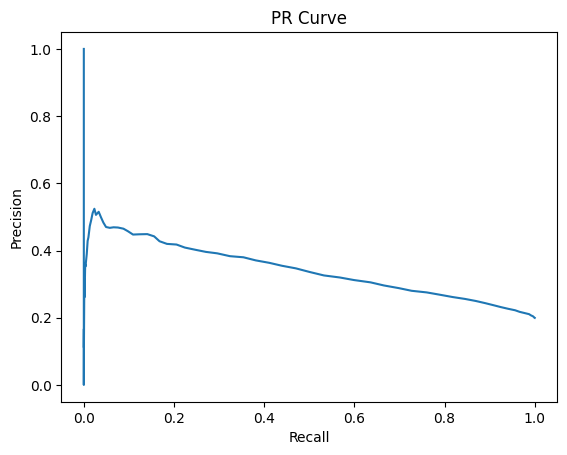

In [38]:
from sklearn.metrics import precision_recall_curve, auc

y_proba = rf_core.predict_proba(X_val)[:,1]
precision, recall, thresholds = precision_recall_curve(y_val, y_proba)
pr_auc = auc(recall, precision)
print(f"PR AUC = {pr_auc:.3f}")

# Plot to visualize
import matplotlib.pyplot as plt
plt.plot(recall, precision)
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR Curve")
plt.show()

In [39]:
# Let's tune our parameters with a randomCV

from sklearn.model_selection import RandomizedSearchCV

# Defining the base estimator (with balanced class weights)
base_rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

# Specifying a distribution of hyperparameters to sample from
param_dist = {
    'n_estimators':      [50, 100, 200, 500],
    'max_depth':         [None, 5, 10, 20, 50],
    'min_samples_leaf':  [1, 2, 5, 10],
    'max_features':      ['auto', 'sqrt', 'log2', 0.2, 0.5],
    'bootstrap':         [True, False]
}

# Setting up the randomized search
rand_search = RandomizedSearchCV(
    estimator=base_rf,
    param_distributions=param_dist,
    n_iter=20,                    # number of candidates to try
    scoring='average_precision',  # average precision = area under PR curve
    cv=3,                         # 3‑fold CV
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Run the search on our training split
rand_search.fit(X_train, y_train)

# Inspect the results
print("Best parameters found:", rand_search.best_params_)
print("Best average precision (PR AUC):", rand_search.best_score_)

# Re‑evaluate on our validation set:
best_rf = rand_search.best_estimator_
y_val_proba = best_rf.predict_proba(X_val)[:,1]
from sklearn.metrics import precision_recall_curve, auc
precision, recall, _ = precision_recall_curve(y_val, y_val_proba)
print("Validation PR AUC:", auc(recall, precision))

Fitting 3 folds for each of 20 candidates, totalling 60 fits


c:\Users\jaked\dsc630\venv\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
9 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\jaked\dsc630\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\jaked\dsc630\venv\Lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "c:\Users\jaked\dsc630\venv\Lib\site-packages\sklearn\base.py", line 469, in _validate_param

Best parameters found: {'n_estimators': 500, 'min_samples_leaf': 10, 'max_features': 0.2, 'max_depth': None, 'bootstrap': True}
Best average precision (PR AUC): 0.35556750003633725
Validation PR AUC: 0.36167381656761144


In [40]:
# Given these results, let's retry our model with the tuned parameters

# Splitting into X/y and train/test
X = df_core[core_feats]
y = df_core['is_default']
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=18
)

# Fitting a Random Forest with our new parameters
rf_core = RandomForestClassifier(
  n_estimators=500,
  max_depth=None,
  min_samples_leaf=10,
  max_features=0.2,
  bootstrap=True,
  class_weight='balanced',
  n_jobs=-1,
  random_state=18
)
rf_core.fit(X_train, y_train)

# Getting the predicted probabilities for the positive class
y_proba = rf_core.predict_proba(X_val)[:, 1]

# Tuneable threshold, let's readjust it up to .75 so we don't bias towards predicting default by too much
threshold = 0.75
y_pred_thresh = (y_proba >= threshold).astype(int)

# Evaluating with confusion matrix and classification report
cm = confusion_matrix(y_val, y_pred_thresh)
print("Confusion Matrix (threshold=%.2f):\n" % threshold, cm)

print("\nClassification Report:")
print(classification_report(y_val, y_pred_thresh))

Confusion Matrix (threshold=0.75):
 [[18478    21]
 [ 4584    27]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89     18499
           1       0.56      0.01      0.01      4611

    accuracy                           0.80     23110
   macro avg       0.68      0.50      0.45     23110
weighted avg       0.75      0.80      0.71     23110



Best F1 at threshold = 0.38:
threshold    0.380000
precision    0.310467
recall       0.664498
f1_score     0.423204
Name: 38, dtype: float64


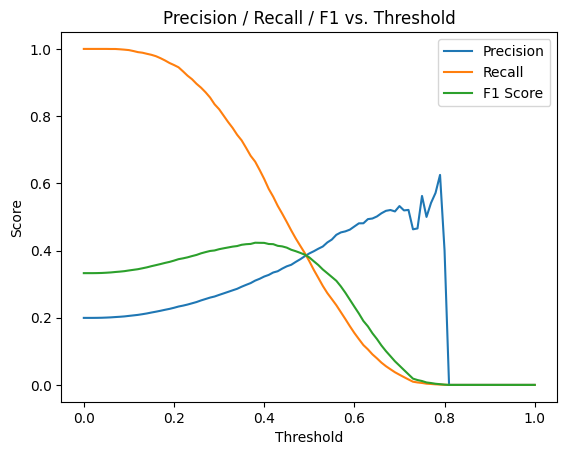

In [41]:
# Rather than keep guessing for an optimized threshold value, let's just conduct a search for the best threshold based on f1 values.

from sklearn.metrics import precision_score, recall_score, f1_score

# Getting your positive‐class probabilities again
y_proba = rf_core.predict_proba(X_val)[:, 1]

# Defining the thresholds we want to try
thresholds = np.linspace(0.0, 1.0, 101)  # 0.00, 0.01, …, 1.00

# Loop and record metrics
records = []
for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    records.append({
        'threshold': t,
        'precision': precision_score(y_val, y_pred, zero_division=0),
        'recall':    recall_score(y_val, y_pred, zero_division=0),
        'f1_score':  f1_score(y_val, y_pred, zero_division=0)
    })

# Building a DataFrame for inspection
results_df = pd.DataFrame(records)

# Peeking at the best F1
best_f1 = results_df.loc[results_df['f1_score'].idxmax()]
print("Best F1 at threshold = {:.2f}:".format(best_f1.threshold))
print(best_f1)

# Plot precision & recall vs. threshold
import matplotlib.pyplot as plt

plt.plot(results_df['threshold'], results_df['precision'], label='Precision')
plt.plot(results_df['threshold'], results_df['recall'],    label='Recall')
plt.plot(results_df['threshold'], results_df['f1_score'],  label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.title('Precision / Recall / F1 vs. Threshold')
plt.show()

In [43]:
# So .38 is the ideal threshold. Let's run one last random forest model with this threshold and evaluate our results before moving
# on to another model to build in the ensemble

# Fitting a Random Forest with the tuned parameters
rf_core = RandomForestClassifier(
  n_estimators=500,
  max_depth=None,
  min_samples_leaf=10,
  max_features=0.2,
  bootstrap=True,
  class_weight='balanced',
  n_jobs=-1,
  random_state=18
)
rf_core.fit(X_train, y_train)

# Getting the predicted probabilities for the positive class
y_proba = rf_core.predict_proba(X_val)[:, 1]

# Tuneable threshold, setting to the ideal .38
threshold = 0.38
y_pred_thresh = (y_proba >= threshold).astype(int)

# Evaluating with confusion matrix and classification report
cm = confusion_matrix(y_val, y_pred_thresh)
print("Confusion Matrix (threshold=%.2f):\n" % threshold, cm)

print("\nClassification Report:")
print(classification_report(y_val, y_pred_thresh))

Confusion Matrix (threshold=0.38):
 [[11694  6805]
 [ 1547  3064]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.63      0.74     18499
           1       0.31      0.66      0.42      4611

    accuracy                           0.64     23110
   macro avg       0.60      0.65      0.58     23110
weighted avg       0.77      0.64      0.67     23110



In [ ]:
# Lastly, let's get our final ROC and PR AUC values

from sklearn.metrics import average_precision_score

# Compute the numeric metrics
roc_auc = roc_auc_score(y_val, y_proba)
pr_auc  = average_precision_score(y_val, y_proba)

print(f"ROC AUC: {roc_auc:.3f}")
print(f"PR  AUC: {pr_auc:.3f}")

ROC AUC: 0.703
PR  AUC: 0.361


This a fairly decent model for predicting default risk from loan applications. With this optimized random forest model, we are able to flag 61% of true defaulters with information at the time of loan origination. Additionally, of all the applications that we flag as defaulters, 31% turn out to be true defaults in the end. Given the business problem, this isn't a horrible result to work with. But I think we will increase our predictive ability even more with the ensemble model. So let's move on to building a true baseline model with a logistic regression using our core features selected in this step.

In [45]:
# LOGISTIC REGRESSION - to be included in the ensemble (not the LR that I did from before just for fun and proof-of-concept)

# Defining X and y from df_core. Was already done, but I'm going to recreate it just in case
X = df_core.drop(columns=['is_default'])
y = df_core['is_default']

# Creating a train/validation split (stratified on the target)
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=18
)

print(f"Training set: {X_train.shape[0]} rows, Validation set: {X_val.shape[0]} rows")

Training set: 92438 rows, Validation set: 23110 rows


Skewness of numeric features:
total_rev_hi_lim         118.409518
annual_inc                12.485300
dti                        8.836544
total_bal_ex_mort          7.597633
avg_cur_bal                4.464308
bc_open_to_buy             3.796070
mths_since_recent_bc       3.535142
tot_cur_bal                3.186734
total_bc_limit             2.884425
mo_sin_old_rev_tl_op       1.100022
earliest_cr_line_days      1.086696
total_acc                  0.939827
loan_amnt                  0.785312
int_rate                   0.723324
mo_sin_old_il_acct         0.393611
revol_util                -0.075374
bc_util                   -0.370565
dtype: float64 

Summary statistics of numeric features:
                         count           mean            std     min  \
int_rate               92438.0      13.248843       4.761730    5.31   
dti                    92413.0      18.192990       9.437055    0.00   
mo_sin_old_il_acct     84817.0     126.154733      52.684365    1.00   
revol_util   

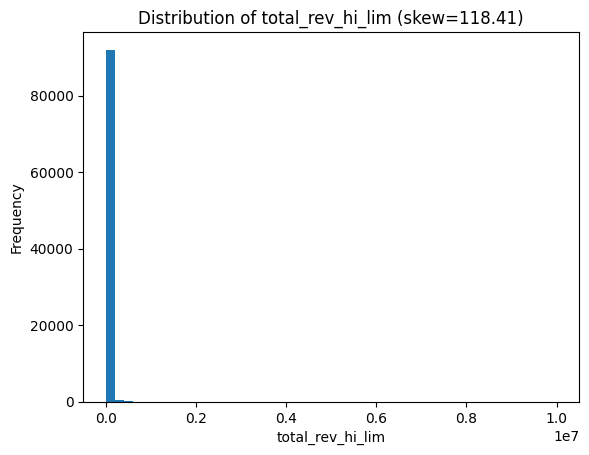

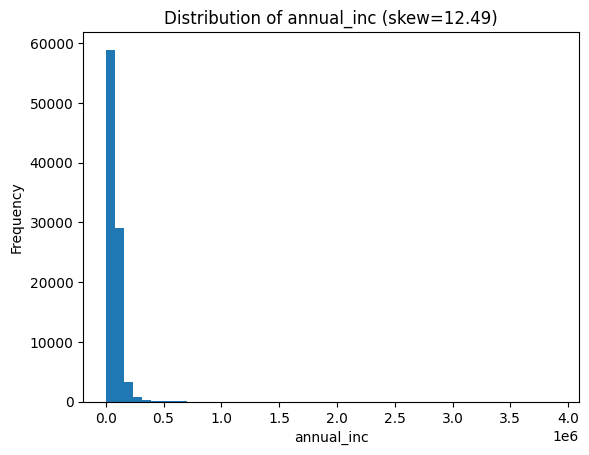

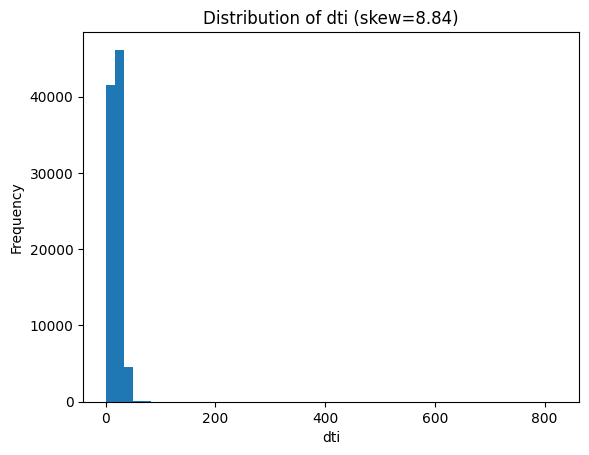

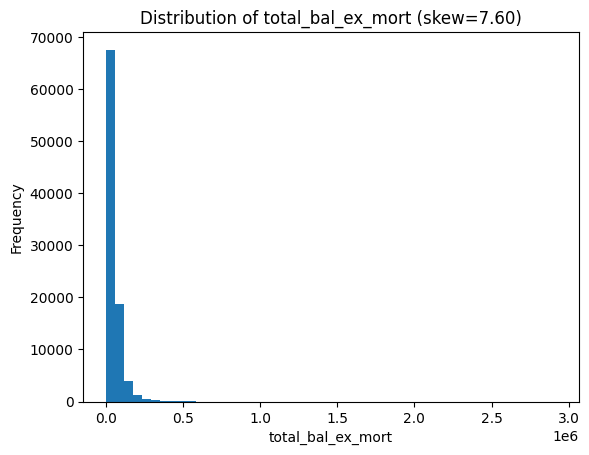

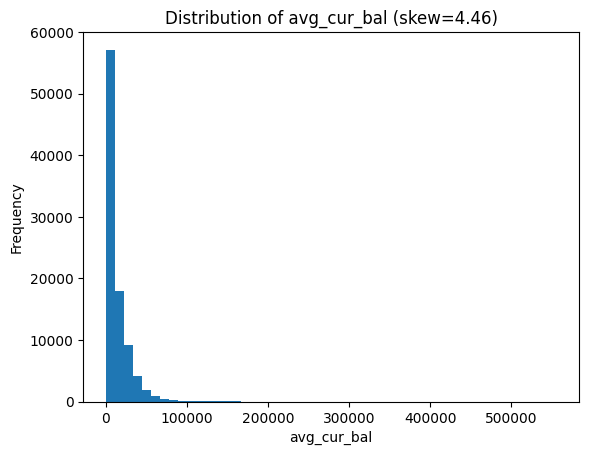

In [46]:
# Now let's look at the skew for each numeric variable in the df_core dataframe. We didn't need to do this with the random 
# forest but now we need to address it before fitting a logistic regression 

# Identifying all numeric columns
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

# Computing skewness for each
skewness = X_train[num_cols].skew().sort_values(ascending=False)
print("Skewness of numeric features:")
print(skewness, "\n")

# Showing summary statistics (with extreme quantiles) for context
summary = X_train[num_cols].describe(percentiles=[.01, .25, .5, .75, .99]).T
print("Summary statistics of numeric features:")
print(summary, "\n")

# Plotting the top 5 most skewed features

top5 = skewness.head(5).index.tolist()
for col in top5:
    plt.figure()
    plt.hist(X_train[col].dropna(), bins=50)
    plt.title(f"Distribution of {col} (skew={skewness[col]:.2f})")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

In [47]:
# So we've got some very heavily right-skewed variables. Let's log transform all variables with a skew north of 1 and then standardize

from sklearn.preprocessing import StandardScaler

# List of the skewed features
log_feats = [
    'total_rev_hi_lim',
    'annual_inc',
    'dti',
    'total_bal_ex_mort',
    'avg_cur_bal',
    'bc_open_to_buy',
    'mths_since_recent_bc',
    'tot_cur_bal',
    'total_bc_limit',
    'earliest_cr_line_days',
    'mo_sin_old_rev_tl_op'
]

# Apply log1p transform in-place on both splits
for df in (X_train, X_val):
    df[log_feats] = np.log1p(df[log_feats])

# Identify all numeric columns (should match our final feature set)
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

# Fit a scaler on train and transform both
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val[num_cols]   = scaler.transform(X_val[num_cols])

# sanity‐check
print("After transform & scale, feature means ≈ 0, std ≈ 1 (train):")
print(np.round(X_train[num_cols].mean(),2).head())
print(np.round(X_train[num_cols].std(),2).head())

After transform & scale, feature means ≈ 0, std ≈ 1 (train):
int_rate             -0.0
dti                   0.0
mo_sin_old_il_acct   -0.0
revol_util           -0.0
bc_open_to_buy        0.0
dtype: float64
int_rate              1.0
dti                   1.0
mo_sin_old_il_acct    1.0
revol_util            1.0
bc_open_to_buy        1.0
dtype: float64


In [48]:
# We will now have to deal with NaNs and impute them. The documentation isn't the greatest so I'm having to make guesses on the true
# meaning of the NaNs in the data. I'm going to zero-fill a couple variables where I think the missing data could possibly mean 0 and
# then median-fill the rest of the numeric columns.

from sklearn.impute import SimpleImputer

# Listing out the columns for each strategy
zero_fill_cols = [
    'bc_open_to_buy',
    'mths_since_recent_bc',
]

# everything else numerical gets median
num_cols = X_train.select_dtypes(include='number').columns.tolist()
median_fill_cols = [c for c in num_cols if c not in zero_fill_cols]

# Fitting, applying the zero‐fill imputer
zero_imp = SimpleImputer(strategy='constant', fill_value=0)
X_train[zero_fill_cols] = zero_imp.fit_transform(X_train[zero_fill_cols])
X_val  [zero_fill_cols] = zero_imp.transform   (X_val[zero_fill_cols])

# Fitting, applying the median‐imputer
med_imp = SimpleImputer(strategy='median')
X_train[median_fill_cols] = med_imp.fit_transform(X_train[median_fill_cols])
X_val  [median_fill_cols] = med_imp.transform   (X_val[median_fill_cols])

In [49]:
# We are ready to fit and train a logistic regression now. 

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, auc

# Instantiating the model
logreg = LogisticRegression(
    class_weight='balanced', 
    max_iter=1000,            # ensure convergence
    solver='lbfgs',           # default solver
    random_state=42
)

# Fitting on our transformed & scaled training data
logreg.fit(X_train, y_train)

# Getting predicted probabilities on the validation set
y_proba_lr = logreg.predict_proba(X_val)[:, 1]

# Choosing a threshold. Let's go back with a normal .5 threshold
threshold = 0.50
y_pred_lr = (y_proba_lr >= threshold).astype(int)

# Confusion matrix & classification report
cm = confusion_matrix(y_val, y_pred_lr)
print(f"Confusion Matrix (threshold={threshold}):\n{cm}\n")
print("Classification Report:\n", classification_report(y_val, y_pred_lr))

# AUC metrics
roc_auc = roc_auc_score(y_val, y_proba_lr)
precision, recall, _ = precision_recall_curve(y_val, y_proba_lr)
pr_auc  = auc(recall, precision)
print(f"ROC AUC: {roc_auc:.3f}")
print(f"PR  AUC: {pr_auc:.3f}")

Confusion Matrix (threshold=0.5):
[[12079  6420]
 [ 1660  2951]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.65      0.75     18499
           1       0.31      0.64      0.42      4611

    accuracy                           0.65     23110
   macro avg       0.60      0.65      0.59     23110
weighted avg       0.77      0.65      0.68     23110

ROC AUC: 0.698
PR  AUC: 0.361


In [50]:
# Let's do another grid search to find the optimal parameters for the logistic regression. 

from sklearn.model_selection import GridSearchCV

# Defining the model (we’ll let solver choose based on penalty)
base_lr = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)

# Making our grid of hyperparameters
param_grid = {
    'penalty': ['l1', 'l2'],
    'C':       [0.01, 0.1, 1, 10, 100],
    'solver':  ['liblinear']    # liblinear supports both l1 and l2
}

# Setting up grid search
grid_lr = GridSearchCV(
    estimator=base_lr,
    param_grid=param_grid,
    scoring='average_precision',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Running on training data
grid_lr.fit(X_train, y_train)

# Inspecting the best params & score
print("Best params:", grid_lr.best_params_)
print("Best PR‑AUC:", grid_lr.best_score_)

# Finally, evaluating on the validation set
best_lr = grid_lr.best_estimator_
y_val_proba = best_lr.predict_proba(X_val)[:,1]
from sklearn.metrics import precision_recall_curve, auc
precision, recall, _ = precision_recall_curve(y_val, y_val_proba)
print("Validation PR‑AUC:", auc(recall, precision))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best params: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best PR‑AUC: 0.3509923442180163
Validation PR‑AUC: 0.36059247554802326


In [51]:
# Now that we have our optimal parameters for the logistic regression using these predictors, let's build it.

# Instantiating the logistic with the tuned hyperparameters
best_lr = LogisticRegression(
    C=10,
    penalty='l2',
    solver='liblinear',
    class_weight='balanced',
    max_iter=1000,
    random_state=18
)

# Fitting on our training data
best_lr.fit(X_train, y_train)

# Getting predicted probabilities on validation set
y_proba_lr = best_lr.predict_proba(X_val)[:, 1]

# Applying our chosen threshold of .50 for good balance between precision and recall
threshold = 0.50
y_pred_lr = (y_proba_lr >= threshold).astype(int)

# Compute and print evaluation metrics
print(f"Confusion Matrix (threshold={threshold}):")
print(confusion_matrix(y_val, y_pred_lr))

print("\nClassification Report:")
print(classification_report(y_val, y_pred_lr))

# Compute AUCs
roc_auc = roc_auc_score(y_val, y_proba_lr)
precision, recall, _ = precision_recall_curve(y_val, y_proba_lr)
pr_auc = auc(recall, precision)

print(f"\nROC AUC: {roc_auc:.3f}")
print(f"PR  AUC: {pr_auc:.3f}")

Confusion Matrix (threshold=0.5):
[[12075  6424]
 [ 1661  2950]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.65      0.75     18499
           1       0.31      0.64      0.42      4611

    accuracy                           0.65     23110
   macro avg       0.60      0.65      0.59     23110
weighted avg       0.77      0.65      0.68     23110


ROC AUC: 0.698
PR  AUC: 0.361


In [52]:
# Let's find what the best threshold is to optimize F1 score (for best overall model performance)

# Getting precision, recall and thresholds from our probs
precision, recall, thresholds = precision_recall_curve(y_val, y_proba_lr)

# Computing F1 scores for each threshold
# Note: `precision` and `recall` are length = len(thresholds)+1
# So I'll drop the last precision/recall to align with `thresholds`
f1_scores = 2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1])

# Finding the best threshold
best_idx       = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1        = f1_scores[best_idx]

print(f"Best threshold for max F1: {best_threshold:.3f}")
print(f"F1 at this threshold:      {best_f1:.3f}")

Best threshold for max F1: 0.497
F1 at this threshold:      0.422


It looks like the optimal threshold value was actually 0.5 which is what we used as a baseline, so we don't actually need to change the model at all. Let's move on to the final model we need to build for the ensemble, an XGBoost. 

In [60]:
# Alright now the last model to build is the xgboost. It should take the same df_core as the random forest

import xgboost as xgb
from xgboost import XGBClassifier, callback

# Building DMatrices for training and validation (I have an older version of XGBoost in my venv)
dtrain = xgb.DMatrix(X_train, label=y_train)
dval   = xgb.DMatrix(X_val,   label=y_val)

# Setting up our parameters
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos

params = {
    'objective':        'binary:logistic',
    'eval_metric':      'aucpr',        # monitor PR‑AUC
    'max_depth':        6,
    'eta':              0.1,
    'subsample':        0.8,
    'colsample_bytree': 0.8,
    'scale_pos_weight': scale_pos_weight,
    'seed':             42
}

# Train with early stopping on the validation set
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,               # allow up to 1000 trees
    evals=[(dtrain, 'train'), (dval, 'eval')],
    early_stopping_rounds=10,
    verbose_eval=True
)

# Inspect how many trees were used
print("Best iteration (trees):", bst.best_iteration)

# Predicting probabilities on the validation set, using only up to the best iteration
y_proba_xgb = bst.predict(
    dval,
    iteration_range=(0, bst.best_iteration)
)

# Compute PR‑AUC and ROC AUC
precision, recall, _ = precision_recall_curve(y_val, y_proba_xgb)
print("XGBoost PR AUC:", auc(recall, precision))

roc_auc = roc_auc_score(y_val, y_proba_xgb)
print("XGBoost ROC AUC:", roc_auc)

# Confusion matrix and classification report at threshold = 0.50 (we'll find  an optimal value later, but 0.50 seems to a pretty good starting point)
threshold = 0.50
y_pred_xgb = (y_proba_xgb >= threshold).astype(int)

print(f"\nConfusion Matrix (threshold={threshold}):")
print(confusion_matrix(y_val, y_pred_xgb))

print("\nClassification Report:")
print(classification_report(y_val, y_pred_xgb))

[0]	train-aucpr:0.30074	eval-aucpr:0.27825
[1]	train-aucpr:0.30873	eval-aucpr:0.28141
[2]	train-aucpr:0.35441	eval-aucpr:0.32975
[3]	train-aucpr:0.36659	eval-aucpr:0.34488
[4]	train-aucpr:0.37133	eval-aucpr:0.35076
[5]	train-aucpr:0.37306	eval-aucpr:0.35463
[6]	train-aucpr:0.37377	eval-aucpr:0.35661
[7]	train-aucpr:0.37475	eval-aucpr:0.35732
[8]	train-aucpr:0.37756	eval-aucpr:0.35699
[9]	train-aucpr:0.37884	eval-aucpr:0.35768
[10]	train-aucpr:0.37976	eval-aucpr:0.35862
[11]	train-aucpr:0.38012	eval-aucpr:0.35931
[12]	train-aucpr:0.38105	eval-aucpr:0.35989
[13]	train-aucpr:0.38151	eval-aucpr:0.35949
[14]	train-aucpr:0.38228	eval-aucpr:0.36012
[15]	train-aucpr:0.38318	eval-aucpr:0.36088
[16]	train-aucpr:0.38398	eval-aucpr:0.36088
[17]	train-aucpr:0.38497	eval-aucpr:0.36053
[18]	train-aucpr:0.38649	eval-aucpr:0.36100
[19]	train-aucpr:0.38832	eval-aucpr:0.36145
[20]	train-aucpr:0.39017	eval-aucpr:0.36121
[21]	train-aucpr:0.39102	eval-aucpr:0.36159
[22]	train-aucpr:0.39255	eval-aucpr:0.3611

Best F1 at threshold = 0.53:
threshold    0.530000
precision    0.328438
recall       0.596617
f1_score     0.423654
Name: 53, dtype: float64


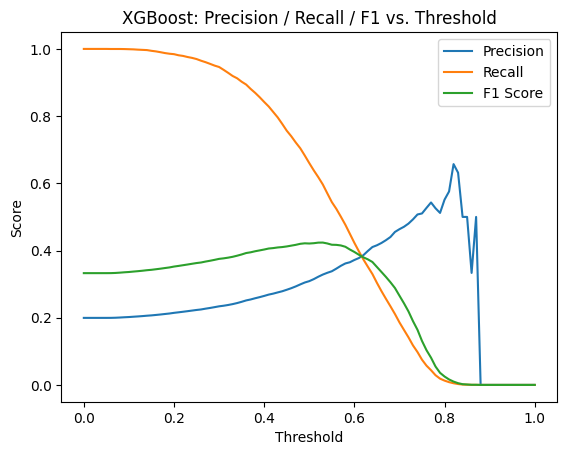

In [55]:
# The XGBoost looks pretty in-line with the other models we have built so far. Let's see if we can find an optimal threshold 

# Defining thresholds to test
thresholds = np.linspace(0.0, 1.0, 101)

# Evaluating metrics at each threshold
records = []
for t in thresholds:
    y_pred = (y_proba_xgb >= t).astype(int)
    records.append({
        'threshold': t,
        'precision': precision_score(y_val, y_pred, zero_division=0),
        'recall':    recall_score(y_val, y_pred, zero_division=0),
        'f1_score':  f1_score(y_val, y_pred, zero_division=0)
    })

results_df = pd.DataFrame(records)

# Finding the threshold giving the best F1
best = results_df.loc[results_df['f1_score'].idxmax()]
print(f"Best F1 at threshold = {best.threshold:.2f}:")
print(best)

# Plotting Precision, Recall and F1 vs Threshold
plt.plot(results_df['threshold'], results_df['precision'], label='Precision')
plt.plot(results_df['threshold'], results_df['recall'],    label='Recall')
plt.plot(results_df['threshold'], results_df['f1_score'],  label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('XGBoost: Precision / Recall / F1 vs. Threshold')
plt.legend()
plt.show()

In [61]:
# Let's update our model with the .53 optimized threshold:

# Confusion matrix and classification report
threshold = 0.53
y_pred_xgb = (y_proba_xgb >= threshold).astype(int)

print(f"\nConfusion Matrix (threshold={threshold}):")
print(confusion_matrix(y_val, y_pred_xgb))

print("\nClassification Report:")
print(classification_report(y_val, y_pred_xgb))

# PR-AUC and ROC AUC:
roc_auc = roc_auc_score(y_val, y_proba_xgb)
print("XGBoost ROC AUC:", roc_auc)

precision, recall, _ = precision_recall_curve(y_val, y_proba_xgb)
print("XGBoost PR AUC:", auc(recall, precision))


Confusion Matrix (threshold=0.53):
[[12874  5625]
 [ 1860  2751]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.70      0.77     18499
           1       0.33      0.60      0.42      4611

    accuracy                           0.68     23110
   macro avg       0.60      0.65      0.60     23110
weighted avg       0.76      0.68      0.70     23110

XGBoost ROC AUC: 0.7048376855178031
XGBoost PR AUC: 0.3634002220916952


In [63]:
# Now that we have three decent models, let's see if we can squeeze out some added benefits from doing a simple blended ensemble

# Step 1 is to get each model’s default‐class probabilities on the validation set
proba_rf  = rf_core .predict_proba(X_val)[:, 1]
proba_lr  = best_lr  .predict_proba(X_val)[:, 1]

# For XGBoost, build the DMatrix
dval      = xgb.DMatrix(X_val)
proba_xgb = bst.predict(dval, iteration_range=(0, bst.best_iteration))

# Simple average‐blend of the three
proba_blend = (proba_rf + proba_lr + proba_xgb) / 3

# Choosing a threshold (will probably sweep this like we did before to get the optimal value)
threshold = 0.50
y_pred_blend = (proba_blend >= threshold).astype(int)

# Evaluate the blend with confusion matrix and report
print("Ensemble Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_blend))

print("\nEnsemble Classification Report:")
print(classification_report(y_val, y_pred_blend))

# Moment of truth, computing PR AUC and ROC AUC for the ensemble
precision, recall, _ = precision_recall_curve(y_val, proba_blend)
print("Ensemble PR AUC:", auc(recall, precision))

roc_auc = roc_auc_score(y_val, proba_blend)
print("Ensemble ROC AUC:", roc_auc)

Ensemble Confusion Matrix:
[[15578  2921]
 [ 2796  1815]]

Ensemble Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.84      0.84     18499
           1       0.38      0.39      0.39      4611

    accuracy                           0.75     23110
   macro avg       0.62      0.62      0.62     23110
weighted avg       0.76      0.75      0.75     23110

Ensemble PR AUC: 0.36794026596621937
Ensemble ROC AUC: 0.7046207131724777


Ensemble best F1 at threshold = 0.43:
threshold    0.430000
precision    0.315511
recall       0.646281
f1_score     0.424018
Name: 43, dtype: float64


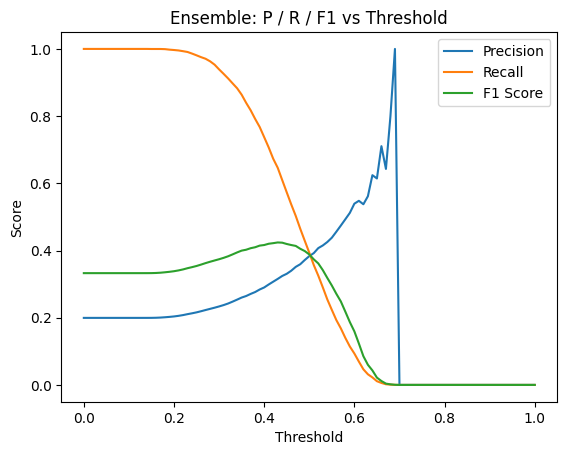

In [64]:
# Ugh, that doesn't look that much better on the surface. We'll dig a little deeper but let's first sweep for an optimal threshold again. 

# define thresholds
thresholds = np.linspace(0, 1, 101)

# compute metrics at each threshold
records = []
for t in thresholds:
    y_pred = (proba_blend >= t).astype(int)
    records.append({
        'threshold': t,
        'precision': precision_score(y_val, y_pred, zero_division=0),
        'recall':    recall_score(y_val, y_pred, zero_division=0),
        'f1_score':  f1_score(y_val, y_pred, zero_division=0)
    })

results = pd.DataFrame(records)

# find best F1
best = results.loc[results['f1_score'].idxmax()]
print(f"Ensemble best F1 at threshold = {best.threshold:.2f}:")
print(best)

# plot the curves
plt.plot(results.threshold, results.precision, label='Precision')
plt.plot(results.threshold, results.recall,    label='Recall')
plt.plot(results.threshold, results.f1_score,  label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Ensemble: P / R / F1 vs Threshold')
plt.legend()
plt.show()

In [67]:
# re-running with the .43 threshold

threshold = 0.43
y_pred_blend = (proba_blend >= threshold).astype(int)

# Evaluate the blend with confusion matrix and report
print("Ensemble Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_blend))

print("\nEnsemble Classification Report:")
print(classification_report(y_val, y_pred_blend))

# Moment of truth, computing PR AUC for the ensemble
precision, recall, _ = precision_recall_curve(y_val, proba_blend)
print("Ensemble PR AUC:", auc(recall, precision))

roc_auc = roc_auc_score(y_val, proba_blend)
print("Ensemble ROC AUC:", roc_auc)

Ensemble Confusion Matrix:
[[12034  6465]
 [ 1631  2980]]

Ensemble Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.65      0.75     18499
           1       0.32      0.65      0.42      4611

    accuracy                           0.65     23110
   macro avg       0.60      0.65      0.59     23110
weighted avg       0.77      0.65      0.68     23110

Ensemble PR AUC: 0.36794026596621937
Ensemble ROC AUC: 0.7046207131724777


It will likely be worth it to go back and add more moderately-predictive features that I got rid of. I might have been too aggressive getting down to a small set of core predictors. I've pretty well squeezed all of the predictive value out of these three models and it does not quite approach comparable industry standards in this area. 

Trained on 9243 rows: Train PR AUC = 0.806, Val PR AUC = 0.342
Trained on 23109 rows: Train PR AUC = 0.655, Val PR AUC = 0.347
Trained on 46219 rows: Train PR AUC = 0.543, Val PR AUC = 0.355
Trained on 69328 rows: Train PR AUC = 0.501, Val PR AUC = 0.358
Trained on 92438 rows: Train PR AUC = 0.478, Val PR AUC = 0.358


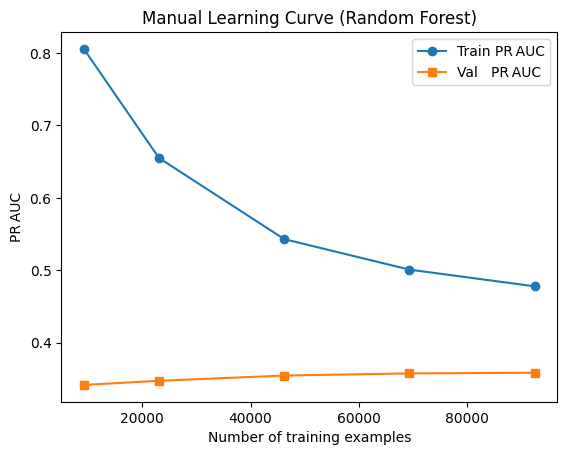

In [ ]:
# Let's test if using more data could possibly increase our model performance. I doubt it, but let's check anyway. I'll only check it for the random forest to save time

# Choosing fractions of the training data to test
fractions = [0.1, 0.25, 0.5, 0.75, 1.0]
n_samples = len(X_train)
train_sizes = [int(frac * n_samples) for frac in fractions]

train_pr = []
val_pr   = []

# For each training‐set size, fit & eval
for n in train_sizes:
    # take the first n rows (you could also random.sample if you prefer)
    X_sub = X_train.iloc[:n]
    y_sub = y_train.iloc[:n]
    
    # training a small RF (fixed hyperparams)
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        class_weight='balanced',
        n_jobs=-1,
        random_state=42
    )
    rf.fit(X_sub, y_sub)
    
    # predict on the subset (train curve)
    p_sub = rf.predict_proba(X_sub)[:,1]
    prec_t, rec_t, _ = precision_recall_curve(y_sub, p_sub)
    train_pr.append(auc(rec_t, prec_t))
    
    # predict on the HOLD‑OUT validation set
    p_val = rf.predict_proba(X_val)[:,1]
    prec_v, rec_v, _ = precision_recall_curve(y_val, p_val)
    val_pr.append(auc(rec_v, prec_v))
    
    print(f"Trained on {n} rows: Train PR AUC = {train_pr[-1]:.3f}, Val PR AUC = {val_pr[-1]:.3f}")

# Plot the learning curves
plt.plot(train_sizes, train_pr, marker='o', label='Train PR AUC')
plt.plot(train_sizes, val_pr,   marker='s', label='Val   PR AUC')
plt.xlabel('Number of training examples')
plt.ylabel('PR AUC')
plt.title('Manual Learning Curve (Random Forest)')
plt.legend()
plt.show()

Adding more data than what we've got won't really produce any meaningful return in terms of model performance. This really suggests that in order to improve the model, we would likely need more/better/engineered features. 

In [69]:
# Overall, my ensemble didn't perform quite as well as I was expecting. But on the other hand, the point of this project is about real value that we can get from
# our predictive model. So let's evaluate my model in this light instead of only focusing on the model metrics themselves. For this analysis, let's be conservative
# and say that a bad loan costs five times more than a good loan profits:

PROFIT_GOOD    = 1000    # expect a good loan to profit $1000  
LOSS_DEFAULT   = 5000   # expect a bad loan to cost us $5000

thresholds = np.linspace(0, 1, 101)
profits = []

for t in thresholds:
    y_pred = (proba_blend >= t).astype(int)

    # Confusion matrix: [[TN, FP], [FN, TP]]
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

    # Under model:
    #  - We fund all predicted‐good = TN + FN
    #  - Of those, TN are good loans → earn PROFIT_GOOD each
    #  - FN are bad loans → incur LOSS_DEFAULT each
    net = tn * PROFIT_GOOD - fn * LOSS_DEFAULT
    profits.append(net)

# pick best threshold
best_idx = np.argmax(profits)
best_thr = thresholds[best_idx]
best_profit = profits[best_idx]

print(f"Best threshold for profit: {best_thr:.2f}, Net profit = ${best_profit:,.0f}")

Best threshold for profit: 0.39, Net profit = $4,219,000


This is a very nice way of looking at my model's performance. Assuming that a bad loan is only 5x more costly than a good loan is profitable, the ideal threshold for decision-making is .40 (meaning we decline loans with an identified risk above 39%). On our validation dataset, that would equate to over $4,000,000 more in net profit. Expanding this to the entirety of the original dataset, we are looking at several tens of millions of dollars in net profit at the end of the day. 

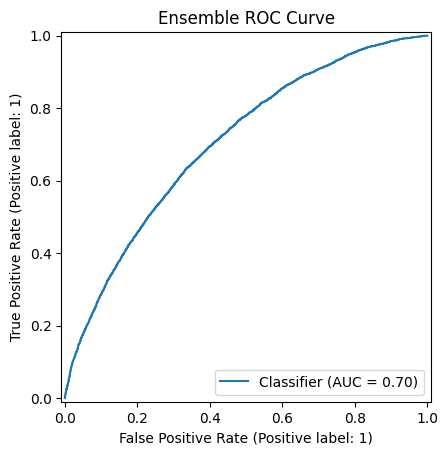

ROC AUC: 0.7046207131724777


In [70]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_val, proba_blend)
plt.title("Ensemble ROC Curve")
plt.show()
print("ROC AUC:", roc_auc_score(y_val, proba_blend))

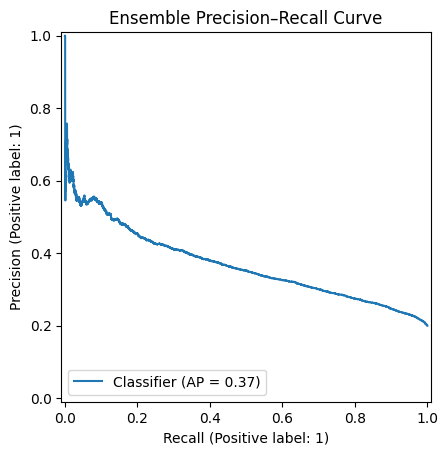

In [71]:
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_predictions(y_val, proba_blend)
plt.title("Ensemble Precision–Recall Curve")
plt.show()

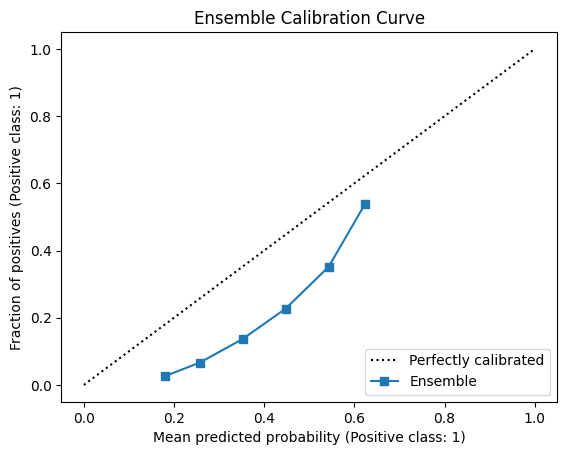

Brier score: 0.18751900734991392


In [72]:
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.metrics import brier_score_loss

# Plotting the reliability diagram
disp = CalibrationDisplay.from_predictions(
    y_val,           # true labels
    proba_blend,     # predicted probabilities
    n_bins=10,       # number of bins
    name="Ensemble"
)
plt.title("Ensemble Calibration Curve")
plt.show()

# Print the Brier score
print("Brier score:", brier_score_loss(y_val, proba_blend))

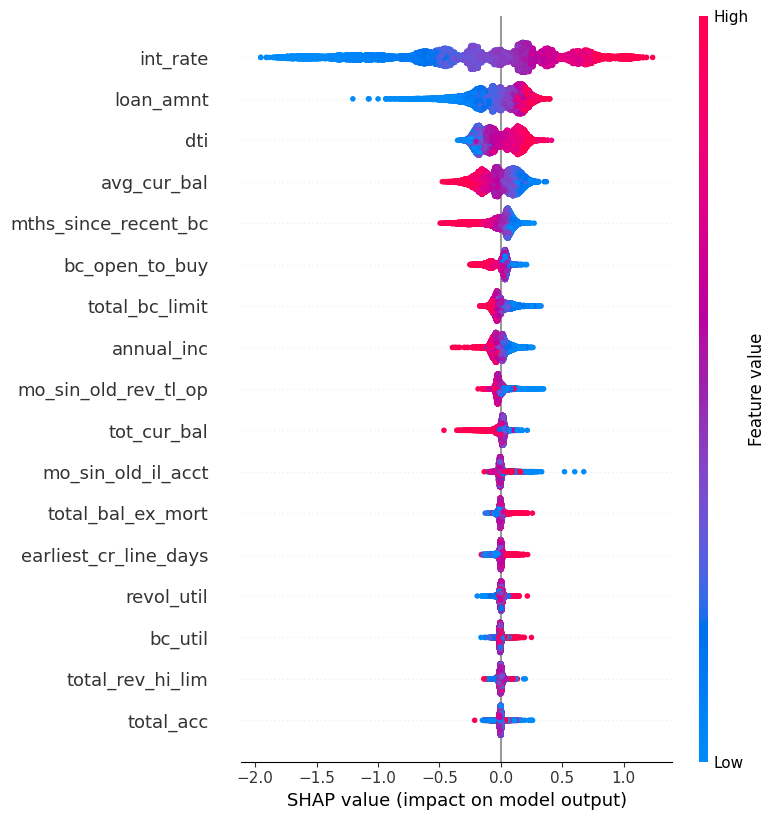

In [ ]:
import shap
explainer = shap.TreeExplainer(bst)  
shap_vals = explainer.shap_values(X_val)
shap.summary_plot(shap_vals, X_val)